In [1]:
import os

# Importing numpy for linear algebra library
import numpy as np

# Importing matplotlib for graph plotting
import matplotlib.pyplot as plt

# Importing all torchvision required for training such as optimizer and transform
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [5]:
# Importing zipfile to unzip dataset
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Wildvat" #name of the folder we want to unzip to

# If the image folder doesn't exist, create new file...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip Expression data
with zipfile.ZipFile("/content/data/Wildvat/Wildcat.zip", "r") as zip_ref:
        print("Unzipping Wildcat images data...")
        zip_ref.extractall(image_path)

data/Wildvat directory exists.
Unzipping Wildcat images data...


In [7]:
image_path = data_path / "Wildvat"

# Walkthrough the data to check the length of each directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 1 directories and 1 images in 'data/Wildvat'.
There are 2 directories and 0 images in 'data/Wildvat/Wildcat'.
There are 10 directories and 0 images in 'data/Wildvat/Wildcat/train'.
There are 0 directories and 233 images in 'data/Wildvat/Wildcat/train/OCELOT'.
There are 0 directories and 236 images in 'data/Wildvat/Wildcat/train/PUMA'.
There are 0 directories and 236 images in 'data/Wildvat/Wildcat/train/AFRICAN LEOPARD'.
There are 0 directories and 236 images in 'data/Wildvat/Wildcat/train/CARACAL'.
There are 0 directories and 238 images in 'data/Wildvat/Wildcat/train/JAGUAR'.
There are 0 directories and 228 images in 'data/Wildvat/Wildcat/train/LIONS'.
There are 0 directories and 231 images in 'data/Wildvat/Wildcat/train/SNOW LEOPARD'.
There are 0 directories and 235 images in 'data/Wildvat/Wildcat/train/CHEETAH'.
There are 0 directories and 237 images in 'data/Wildvat/Wildcat/train/TIGER'.
There are 0 directories and 229 images in 'data/Wildvat/Wildcat/train/CLOUDED LEOPARD

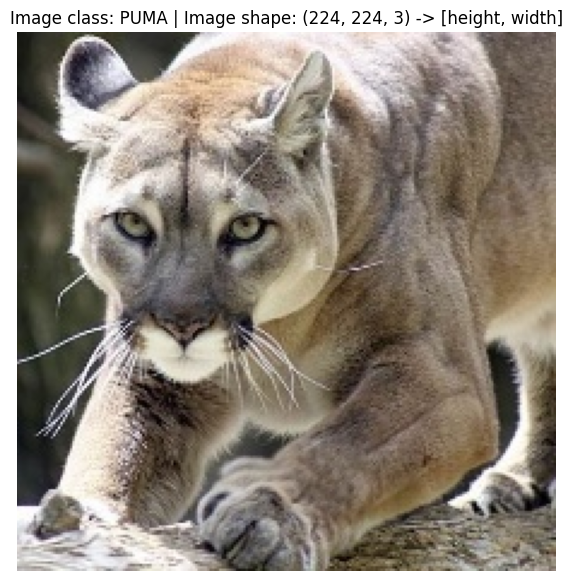

In [9]:
from PIL import Image
import random

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width]")
plt.axis(False);


In [12]:
# Define transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [18]:
# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "/content/data/Wildvat/Wildcat/train"
test_dir = image_path  / "/content/data/Wildvat/Wildcat/test"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=transform_train, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform_test)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2339
    Root location: /content/data/Wildvat/Wildcat/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 50
    Root location: /content/data/Wildvat/Wildcat/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [19]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Create iterators for the Data loaded using DataLoader module
batchSize = 32

trainloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

2339
50


In [43]:
class ConvNetWildcat(nn.Module):
    def __init__(self):
        super(ConvNetWildcat, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [48]:
# Create the model
model = ConvNetWildcat()

# Initializing the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Moving the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Printing the model summary
print(model)

ConvNetWildcat(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [49]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()


            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, 'best_model'+str(epoch)+'.pt')

    return model, history

In [50]:
# 4. Train the model for 15 epochs

num_epochs = 15
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/15
Epoch : 000, Training: Loss: 2.4092, Accuracy: 10.6028%, 
		Validation : Loss : 2.3672, Accuracy: 16.0000%, Time: 6.4598s
Epoch: 2/15
Epoch : 001, Training: Loss: 2.1708, Accuracy: 20.0513%, 
		Validation : Loss : 2.0830, Accuracy: 14.0000%, Time: 7.2609s
Epoch: 3/15
Epoch : 002, Training: Loss: 1.6573, Accuracy: 38.8200%, 
		Validation : Loss : 1.5716, Accuracy: 42.0000%, Time: 6.9237s
Epoch: 4/15
Epoch : 003, Training: Loss: 1.3183, Accuracy: 51.6032%, 
		Validation : Loss : 1.1409, Accuracy: 48.0000%, Time: 7.6282s
Epoch: 5/15
Epoch : 004, Training: Loss: 0.9787, Accuracy: 64.5575%, 
		Validation : Loss : 1.0038, Accuracy: 58.0000%, Time: 7.5946s
Epoch: 6/15
Epoch : 005, Training: Loss: 0.6184, Accuracy: 78.6661%, 
		Validation : Loss : 0.9278, Accuracy: 58.0000%, Time: 6.3122s
Epoch: 7/15
Epoch : 006, Training: Loss: 0.3299, Accuracy: 89.0979%, 
		Validation : Loss : 1.0761, Accuracy: 64.0000%, Time: 7.5011s
Epoch: 8/15
Epoch : 007, Training: Loss: 0.1786, Accuracy: 94.

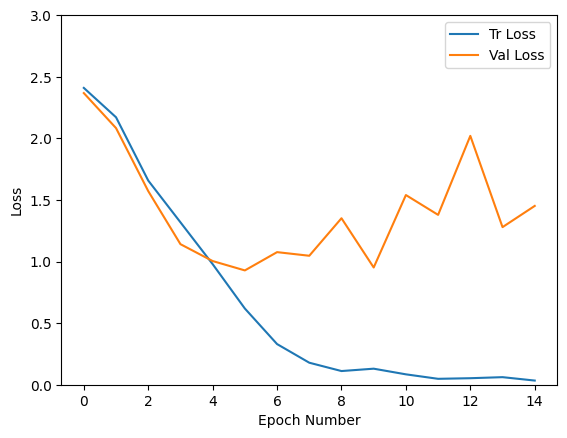

In [51]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('loss_curve.png')
plt.show()

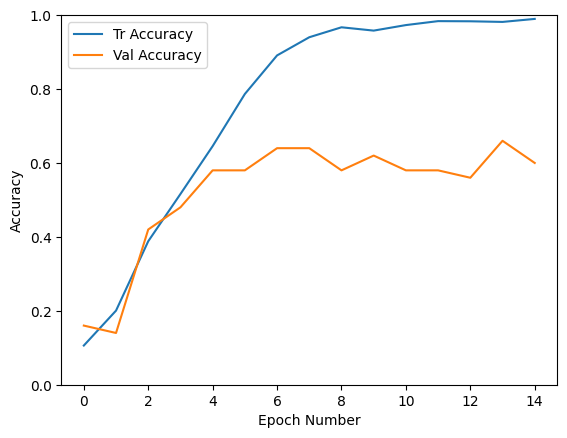

In [52]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('accuracy_curve.png')
plt.show()

In [53]:
# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device) # Move inputs to the same device as the model
        labels = labels.to(device) # Move labels to the same device as the model
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test dataset: {100 * correct / total:.2f}%')

Accuracy on the test dataset: 60.00%
